In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import Slider

plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

# Task A
### $p(x|\theta) = \pi_1 \frac{1}{\sqrt{2\pi\sigma_{c_1}²}} exp(-\frac{1}{2\sigma_{c_1}²}(x-\mu_{c_1})²) + \pi_2 \frac{1}{\sqrt{2\pi\sigma_{c_2}²}} exp(-\frac{1}{2\sigma_{c_2}²}(x-\mu_{c_2})²)$

In [28]:
# Generate samples for two combined gaussian distributions.
# We want to have random samples. Therefore draw N numbers of uniform distribution and if the
# value is below pi_1 (=pi[0]) we draw a value from the first Gaussian and above from the second Gaussian

def gen_samples(N, pi: list, mu: list, sigma: list):
    
    assert all([len(l) == 2 for l in [pi, mu, sigma]]), "Lists need to have the length 2."
    assert round(sum(pi), 6) == 1.0, "Sum of pi_i must equal 1"
    
    randoms = np.random.random(N)
    samples = []
    for r in randoms:
        if r <= pi[0]: 
            samples.append(np.random.normal(mu[0], sigma[0], 1))
        else:
            samples.append(np.random.normal(mu[1], sigma[1], 1))
    
    return np.array(samples).flatten()


In [29]:
# Generative parameters
N = 200

mu1_gen = -2
pi1_gen = 0.4
sigma1_gen = 1

mu2_gen = 4
pi2_gen = 0.6
sigma2_gen = np.sqrt(10)

In [30]:
samples = gen_samples(N, [pi1_gen, pi2_gen], [mu1_gen, mu2_gen], [sigma1_gen, sigma2_gen])

# Task B

In [31]:
mu1_init = -5
pi1_init = 0.5
sigma1_init = 1
mu2_init = 5
pi2_init = 0.5
sigma2_init = np.sqrt(10)

In [32]:
sum([pi1_init, pi2_init]) == 1.0

True

In [33]:
# General gaussian distribution
def gaussian_pdf(x, mu, sigma):
    
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

# Combined Gaussian distribution of arbitrary many Gaussians.
def pdf_combined(x, pi, mu, sigma):
    length = len(pi)
    assert all([len(l) == length for l in [pi, mu, sigma]]), "Lists need to have the same length."
    assert round(sum(pi), 6) == 1.0, "Sum of pi_i must equal 1"

    prob = 0
    for p, m, s in zip(pi, mu, sigma):
        prob += p * gaussian_pdf(x, m, s)
    
    return prob

In [34]:
class MSTEPError(Exception):
    pass

class EMAlgorithm:

    """
    Class that implements the EM algorithm for the 1 dimensional case. 
    This can be applied for gaussian mixture models that consists of K different gaussians.

    parameters:
    
    sample_func: Function to sample the data (generative model)
    N: Number of data points
    K_gaussians: Number of mixture components
    initial_mu: Initial mean value
    initial_sigma: Initial value for the standard deviation
    conv_thr: Convergence threshold for the log-likelihood
    max_steps: maximum number of iterations


    """
    
    def __init__(self, samples, K_gaussians, initial_mu, initial_sigma,
                 initial_pi, conv_thr=0.000001, max_steps=100):
        
        self.K_gaussians = K_gaussians
        self.x = samples 
        self.sigma = initial_sigma
        self.mu = initial_mu
        self.N= self.x.shape[0]
        self.r = None
        self.conv_thr = conv_thr
        self.max_steps = max_steps
        self.pi = np.array(initial_pi)


    def _expectation_step(self):
        
        """
        Performs one expectation step. Formulas see script p. 29, Headline "EM - Algorithm for the mixture of Gaussians model"
        """

        denominator = self._calc_r_denomin()

        self.r = [gaussian_pdf(self.x, self.mu[i], self.sigma[i]) * self.pi[i] / denominator
                  for i in range(self.K_gaussians)]
    
    def _calc_r_denomin(self):

        """
        Calculate denominator for the update rule of r.
        """

        denom = np.array([gaussian_pdf(self.x, self.mu[i], self.sigma[i]) * self.pi[i]
                          for i in range(self.K_gaussians)]).sum(axis=0)

        return denom

    def _maximization_step(self):
        
        """
        Performs one maximization step. Formulas see script top of p. 30
        """

        self.pi = [1 / self.N * self.r[i].sum() 
                    for i in range(self.K_gaussians)]

        self.mu = [(self.x * self.r[i]).sum() / self.r[i].sum() 
                    for i in range(self.K_gaussians)]

        self.sigma = np.sqrt([(((self.x - self.mu[i]) ** 2) * self.r[i]).sum() / self.r[i].sum() 
                    for i in range(self.K_gaussians)])
        
        if np.any(self.r == 0.0) or np.any(self.mu == 0.0) or np.any(self.sigma == 0.0) or np.any(self.pi == 0.0):
            raise MSTEPError
        
        
    def _calculate_gaussian_mixture(self):

        """
        Calculate the probability of x for each gaussian in the gaussian mixture.
        Recall script p. 26 formula (95). For one x_i in the vector x we calculate the likelihood given
        all Gaussians c of the total K_gaussians. Therefore first each column of the matrix (np.array[]) corresponds 
        to one x_1 and each row in this column is the probability density p(x,c|theta) or each c.

        After that we take the sum along axis=0 / axis=rows. Thus, we add all rows on top of each other which means 
        sum p(x,c|theta) other all c. This is now p.

        For the log-likelihood take the log of p and the sum other the vector, thus sum other all x_i in x. Which is done
        in function _calculate_log_likelihood.
        """

        p = np.array([self.pi[i] * gaussian_pdf(self.x, self.mu[i], self.sigma[i]) 
                      for i in range(self.K_gaussians)]).sum(axis=0)

        return p

    def _calculate_log_likelihood(self):

        """
        Calculate the log-likelihood. p is a vector with p(x_i|theta) for all x_i in vector x.
        Take log of p(x_i|theta) and sum other all x_i.
        """

        p = self._calculate_gaussian_mixture()
        log_likelihood = np.log(p).sum()
        
        return log_likelihood
    
    def run(self, print_=True, return_=True, conv=False):

        """
        Run the EM algorithm.

        parameters:

        print_: Whether to print the log-likelihood in each step
        return_: Whether to return the list of log-likelihoods
        conv: Whether to consider the convergence of the log-likelihood to stop the iterations. If False,
              only the maximum number of steps is considered.
        """
        
        converged = False
        step = 0
        log_likelihood = self._calculate_log_likelihood()
        log_likelihood_list = [log_likelihood]
        mu_parameters = [self.mu]
        sigma_parameters = [self.sigma]
        pi_parameters = [self.pi]
        
        if print_:
                print(f"step {step}: {log_likelihood}")
        
        # The actual algorithm
        while not converged and step < self.max_steps:
            
            self._expectation_step()
            self._maximization_step()
            
            prev_log_likelihood = log_likelihood
            log_likelihood = self._calculate_log_likelihood()

            """ Save parameters in array or each iteration """
            log_likelihood_list.append(log_likelihood)
            mu_parameters.append(self.mu)
            sigma_parameters.append(self.sigma)
            pi_parameters.append(self.pi)
            step += 1
            
            if print_:
                print(f"step {step}: {log_likelihood}")
            
            """ Abort early if additional convergence criterium is met even though max_steps were not yet performed """
            if np.abs(log_likelihood - prev_log_likelihood) < self.conv_thr and conv:
                converged = True

        if return_:
            return dict(mu= mu_parameters, sigma=sigma_parameters, pi=pi_parameters, log_likelihood=log_likelihood_list)
    
    def return_final_parameters(self):

        """
        Return the final parameters for the gaussian mixture.
        """
        
        return {"pi": self.pi, "mu": self.mu, "sigma": self.sigma}

In [35]:
EM = EMAlgorithm(samples, 2, [mu1_init, mu2_init], [sigma1_init, sigma2_init], [pi1_init, pi2_init])

In [36]:
parameters = EM.run(print_=False)

In [37]:
%matplotlib widget
# run this cell before you run the cell containing the Slider (below). If you run all cells, then the slider is already closed again since the next cell runs "matplotlib inline".


In [38]:
# Create interactive widget. You can use the slider to show the pdf after each EM iteration
# Furthermore the correct pdf is in orange and the underlying histogram of datapoints for the
# EM algorithm is shown.
fig, ax = plt.subplots(figsize=(6, 8))

x = np.linspace(-10, 15, 1000)
mu = parameters["mu"]
sigma = parameters["sigma"]
pi = parameters["pi"]

ax.hist(samples, bins=51, density=True, alpha=0.7, label="Histogram of $x_n$")
ax.plot(x, pdf_combined(x, pi=[0.4, 0.6], mu=[-2, 4], sigma=[1, np.sqrt(10)]), label="Correct PDF", c="C0")

ax.set_xlabel("Datapoint $x_n$", fontsize=15)
ax.set_ylabel("Probability", fontsize=15)

line, = ax.plot(x, pdf_combined(x, pi[0], mu[0], sigma[0]), label="Approximated PDF", C="C1")
ax.legend()

# Creation of adjustable Slider
ax_sld = plt.axes([0.25, 0.001, 0.65, 0.03])

SLD = Slider(
    ax=ax_sld,
    label="Iteration number",
    valmin=0,
    valmax=len(mu)-1,
    valinit=0,
    valfmt="%i"
)

def update(val):
    line.set_ydata(pdf_combined(x, pi[int(val)], mu[int(val)], sigma[int(val)]))
    fig.canvas.draw_idle()
    
SLD.on_changed(update)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-38-a348d90784b9>:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  line, = ax.plot(x, pdf_combined(x, pi[0], mu[0], sigma[0]), label="Approximated PDF", C="C1")


0

### You can see that the pdf of the EM algorithm approaches the correct pdf with each iteration step. However, due to the limited N=200 datapoints the pdf won't match the correct pdf exactly. The underlying histogram does not represent the correct pdf exactly and therefore we get small deviations from the EM-pdf to the correct pdf

In [39]:
%matplotlib inline

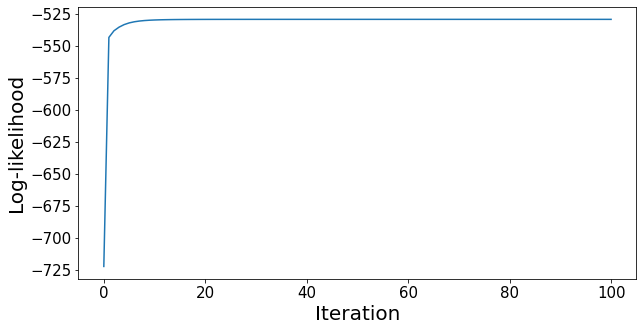

In [40]:
# Plot the evolution of the log_likelihood
log_likelihood = parameters['log_likelihood']

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(log_likelihood)
ax.set_xlabel("Iteration", fontsize=20)
ax.set_ylabel("Log-likelihood", fontsize=20)
plt.show()


In [41]:
# Compare parameters of EM algorithm to generative parameters
final_parameters_task_b = EM.return_final_parameters()
# Round final parameters
pi_rounded = [f'%.3f' % elem for elem in final_parameters_task_b["pi"]]
mu_rounded = [f'%.3f' % elem for elem in final_parameters_task_b["mu"]]
sigma_rounded = [f'%.3f' % elem for elem in final_parameters_task_b["sigma"]]

comparison = []
comparison.append({"Generative parameters": str([pi1_gen, pi2_gen]), "EM-algorithm parameters": str(pi_rounded), "label": "[Pi_1, Pi_2]"})
comparison.append({"Generative parameters": str([mu1_gen, mu2_gen]), "EM-algorithm parameters": str(mu_rounded), "label": "[Mu_1, Mu_2]"})
comparison.append({"Generative parameters": str([sigma1_gen, round(sigma2_gen,3)]), "EM-algorithm parameters": str(sigma_rounded), "label": "[Sigma_1, Sigma_2]"})

df = pd.DataFrame(comparison).set_index("label")
display(df)

,Generative parameters,EM-algorithm parameters
label,,
"[Pi_1, Pi_2]","[0.4, 0.6]","['0.337', '0.663']"
"[Mu_1, Mu_2]","[-2, 4]","['-1.956', '3.818']"
"[Sigma_1, Sigma_2]","[1, 3.162]","['1.014', '3.321']"


### We can see that the parameters by the EM-algorithm are quite close to the generative parameters

# Task C 
### With so few datapoints we run into problems to compute the parameters of the gaussian distribution. When we run into problems, we don't (and cannot) plot the curves. 
### This can be explained as follows. If we take a look at the formulas on p. 30 top and especially $\mu_c^{new} = \frac{\sum_n r_c^{(n)}x^{(n)}}{\sum_n r_c^{(n)}}$ and $(\sigma_c^{new})^2=\frac{\sum_n r_c^{(n)}(x^{(n)}-\mu_c^{new})^2}{\sum_n r_c^{(n)}}$ 
### After some Debugging we found, that some $\sigma_c$ are 0 and this results in a problem because $\sigma$ is in the gaussian distribution in the denominator of the exponential term. Thus, we would devide by 0. 
### The question is: Why do we have $sigma_c$ = 0? According to the formulas this happens if $r_c^{(n)}$ is 0 or $x^{(n)}-\mu_c^{new}$ is 0 for all c. 
### 1. Take a look at the formula of $r_c^{(n)}$. If the x_i value is too far away from the intial gaussian guess, the nominator gets 0 and therefore $r_c^{(n)}$ is 0. This happens because our 5 datapoints are randomly generated. It can happen, that these datapoints are far far away from the intial guess and the exponential function yields very small numbers (~1e-30). 
### 2. This gets problematic if we compute $\mu_c^{(n)}$. Assume only 4 out of 5 datapoints yields to very small $r_c^{(n)}$. Then the summation "picks out" only one $x^{(n)}$ namely $x_i$ . So $\mu_c^{(new)} \approx x_j$
### 3. In the formula for $(\sigma_c^{(new)})^2$ we take the difference of $\mu_c^{(new)}$ and the $x^{(n)}$ vector and get approximately $\sigma_c^{(new)} \approx 0$. The other terms are approximately also 0 because $r_c^{(n)}$ is nearly 0. And now we divide by 0 (in one of the next iterations if sigma gets even smaller) in the exponential function.

### In summary: If we have few datapoints and many of them lie far away from the initial gaussian guess. The $\mu_c^{(new)}$ and $r_c^{(n)}$ just get the right value that $\sigma_c^{(new)}$ is 0.

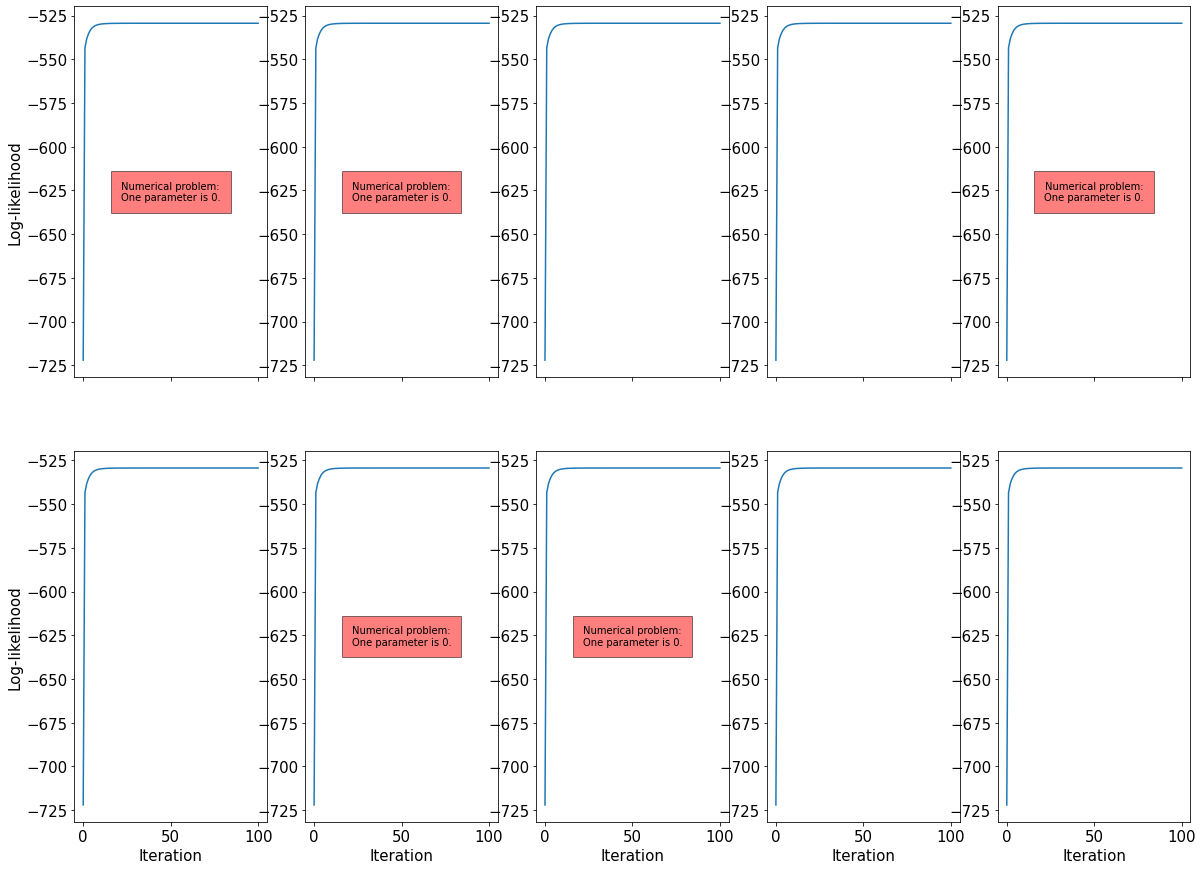

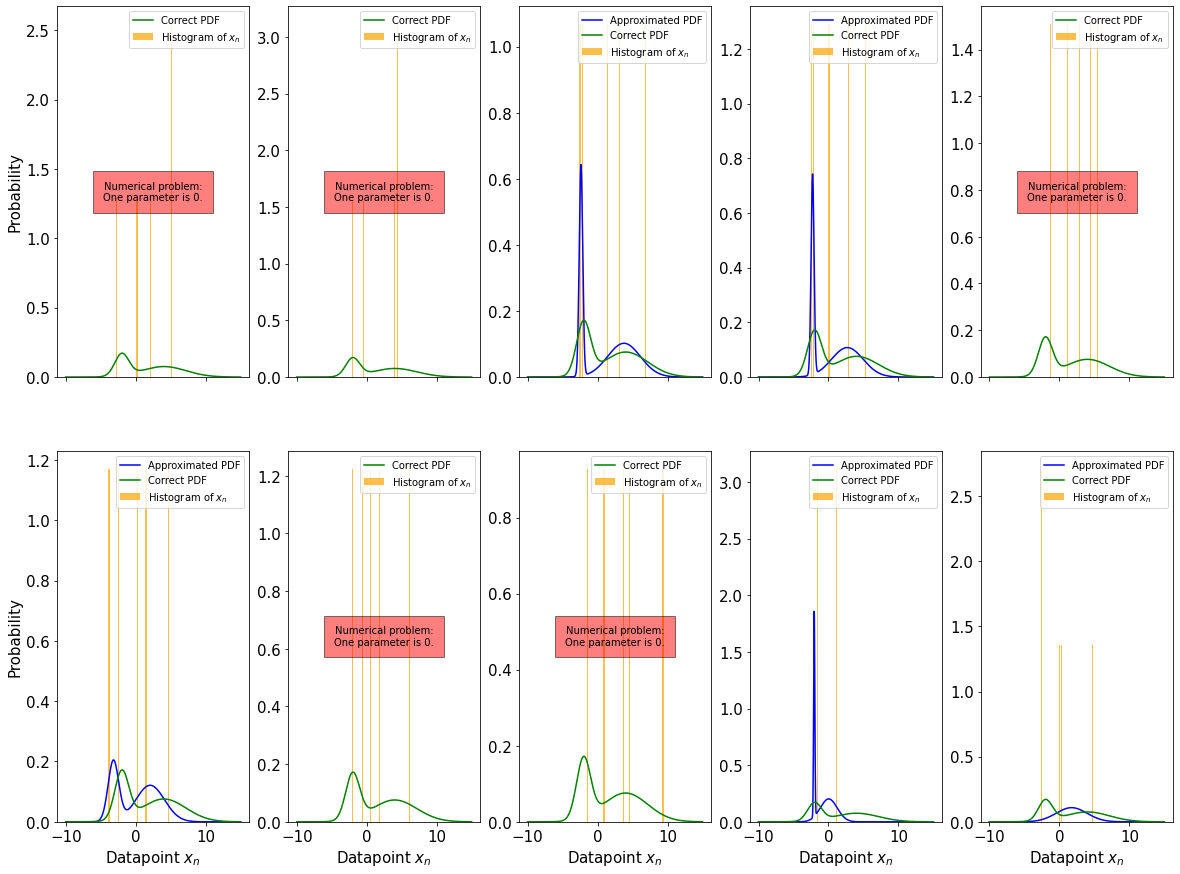

In [42]:
N = 5

fig_log, ax_log = plt.subplots(ncols=5, nrows=2, figsize=(20, 15), sharex=True, sharey=False)
fig_pdf, ax_pdf = plt.subplots(ncols=5, nrows=2, figsize=(20, 15), sharex=True, sharey=False)

for i in range(10):
    samples = gen_samples(N, [pi1_gen, pi2_gen], [mu1_gen, mu2_gen], [sigma1_gen, sigma2_gen])
    approximated = True
    EM = EMAlgorithm(samples, 2, [mu1_init, mu2_init], [sigma1_init, sigma2_init], [pi1_init, pi2_init])
    
    try:
        parameters = EM.run(print_=False)
    except MSTEPError:
        ax_log[i // 5, i % 5].text(0.5, 0.5, "Numerical problem:\nOne parameter is 0.",
                                   bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}, 
                                   transform=ax_log[i // 5, i % 5].transAxes, ha="center", va="center")
        ax_pdf[i // 5, i % 5].text(0.5, 0.5, "Numerical problem:\nOne parameter is 0.",
                                   bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}, 
                                   transform=ax_pdf[i // 5, i % 5].transAxes, ha="center", va="center")
        approximated = False
        
    final_parameters = EM.return_final_parameters()
    pi = final_parameters["pi"]
    mu = final_parameters["mu"]
    sigma = final_parameters["sigma"]
    if i // 5 == 1:
        ax_log[i // 5, i % 5].set_xlabel("Iteration", fontsize=15)
        ax_pdf[i // 5, i % 5].set_xlabel("Datapoint $x_n$", fontsize=15)
    if i % 5 == 0:
        ax_log[i // 5, i % 5].set_ylabel("Log-likelihood", fontsize=15)
        ax_pdf[i // 5, i % 5].set_ylabel("Probability", fontsize=15)
    
    if approximated:
        ax_pdf[i // 5, i % 5].plot(x, pdf_combined(x, pi, mu, sigma), label="Approximated PDF", color="blue")
    
    ax_pdf[i // 5, i % 5].plot(x, pdf_combined(x, pi=[0.4, 0.6], mu=[-2, 4], sigma=[1, np.sqrt(10)]), label="Correct PDF", color="green")
    ax_pdf[i // 5, i % 5].hist(samples, bins=51, density=True, alpha=0.7, label="Histogram of $x_n$", color="orange")
    ax_log[i // 5, i % 5].plot(log_likelihood)
    
    ax_pdf[i // 5, i % 5].legend()
    

# Task D

In [43]:
mu_start = list(zip(np.random.uniform(-8, 3, 10), np.random.uniform(3.1, 10, 10)))
sigma_start = list(zip(np.random.uniform(0.2, 3, 10), np.random.uniform(0.2, 6, 10)))
pi_start = np.random.uniform(size=10)
pi_start = list(zip(pi_start, 1 - pi_start))

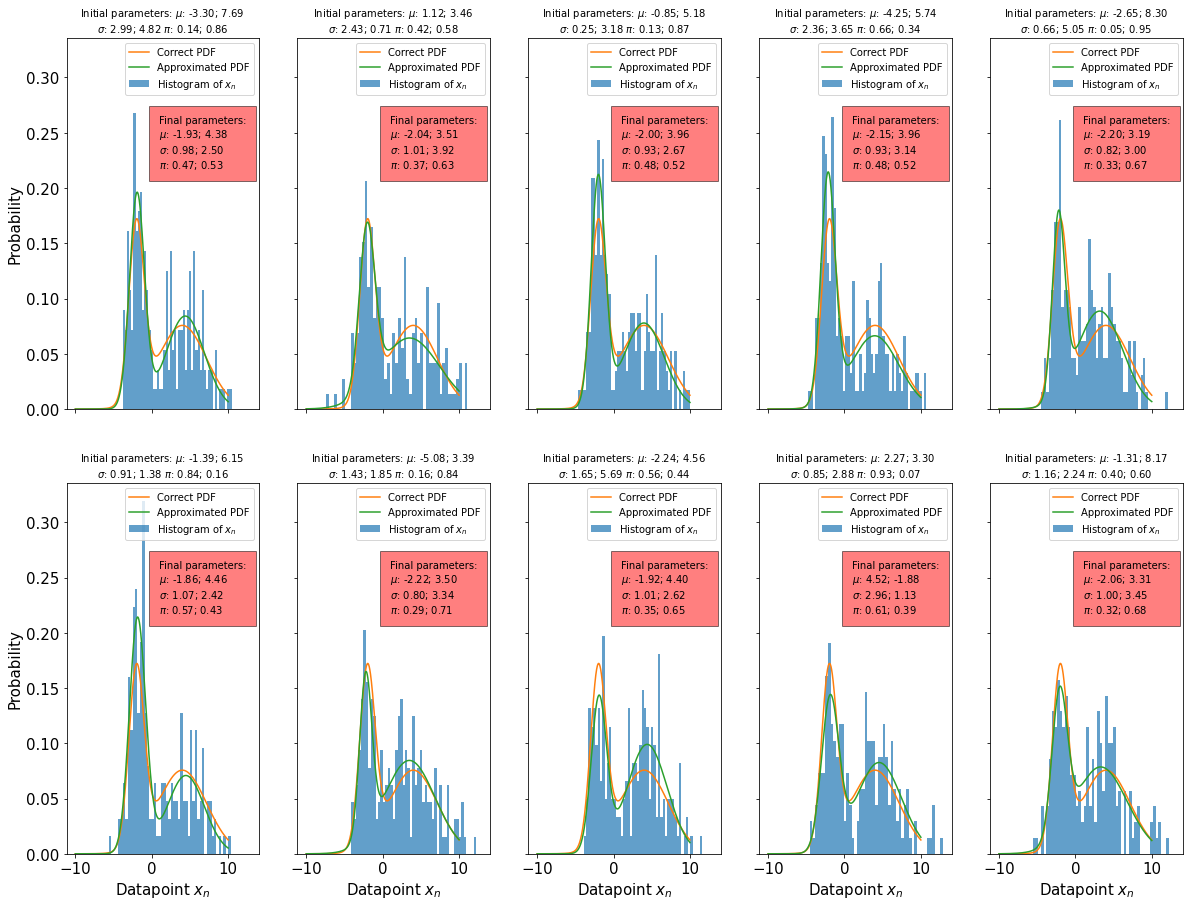

In [50]:
N = 200

#fig_log, ax_log = plt.subplots(ncols=5, nrows=2, figsize=(20, 15), sharex=True, sharey=True)
fig_pdf, ax_pdf = plt.subplots(ncols=5, nrows=2, figsize=(20, 15), sharex=True, sharey=True)



for i in range(10):
    samples = gen_samples(N, [pi1_gen, pi2_gen], [mu1_gen, mu2_gen], [sigma1_gen, sigma2_gen])
    EM = EMAlgorithm(samples, 2, mu_start[i], sigma_start[i], pi_start[i])
    parameters = EM.run(print_=False)
    
    final_parameters = EM.return_final_parameters()
    pi = final_parameters["pi"]
    mu = final_parameters["mu"]
    sigma = final_parameters["sigma"]
    
    title = "Initial parameters: $\mu$: {:.2f}; {:.2f} \n$\sigma$: {:.2f}; {:.2f} $\pi$: {:.2f}; {:.2f}".format(*mu_start[i], *sigma_start[i], *pi_start[i]) 
    ax_pdf[i // 5, i % 5].set_title(title, fontsize=10)
    results = "Final parameters:\n$\mu$: {:.2f}; {:.2f}\n$\sigma$: {:.2f}; {:.2f}\n$\pi$: {:.2f}; {:.2f}".format(*mu, *sigma, *pi)
    ax_pdf[i // 5, i % 5].text(0.48, 0.65, results, bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}, transform=ax_pdf[i // 5, i % 5].transAxes)
    
    #ax_log[i // 5, i % 5].plot(log_likelihood)
    if i // 5 == 1:
        #ax_log[i // 5, i % 5].set_xlabel("Iteration", fontsize=15)
        ax_pdf[i // 5, i % 5].set_xlabel("Datapoint $x_n$", fontsize=15)
    if i % 5 == 0:
        #ax_log[i // 5, i % 5].set_ylabel("Loglikelyhood", fontsize=15)
        ax_pdf[i // 5, i % 5].set_ylabel("Probability", fontsize=15)
    
    ax_pdf[i // 5, i % 5].hist(samples, bins=51, density=True, alpha=0.7, label="Histogram of $x_n$")
    ax_pdf[i // 5, i % 5].plot(x, pdf_combined(x, pi=[0.4, 0.6], mu=[-2, 4], sigma=[1, np.sqrt(10)]), label="Correct PDF")
    ax_pdf[i // 5, i % 5].plot(x, pdf_combined(x, pi, mu, sigma), label="Approximated PDF")
    
    ax_pdf[i // 5, i % 5].legend()
        

## Overall, the different approximations look quite similiar (except for subplot 2). Even in the case of initial parameters that differ significantly from the ones that were used for the data generation, the final parameters approximate the generative parameters quite well. Moreover, the second subplot emphasizes that you can reach local minima which lead to incorrect approximations. In this case $pi_2$ is 0 and therefore the result consists only of one gaussian.

# Task E

In [45]:
def intersect(p1, p2):
    idxs = np.argwhere(np.diff(np.sign(p1 - p2))).flatten()
    return idxs

In [46]:
final_parameters_task_b

{'pi': [0.33727644290339315, 0.662723557096607],
 'mu': [-1.9555892602827756, 3.8178734790757467],
 'sigma': array([1.01412328, 3.32085881])}

In [47]:
x = np.linspace(-10, 10, 10000)

p_1 = gaussian_pdf(x, final_parameters_task_b["mu"][0], final_parameters_task_b["sigma"][0]) * final_parameters_task_b["pi"][0]
p_2 = gaussian_pdf(x, final_parameters_task_b["mu"][1], final_parameters_task_b["sigma"][1]) * final_parameters_task_b["pi"][0]

posterior_1 = p_1 / (p_1 + p_2)
posterior_2 = p_2 / (p_1 + p_2)

dec_bound = intersect(posterior_1, posterior_2)

In [48]:
dec_bound

array([2453, 4996])

Text(0, 0.5, 'Probability')

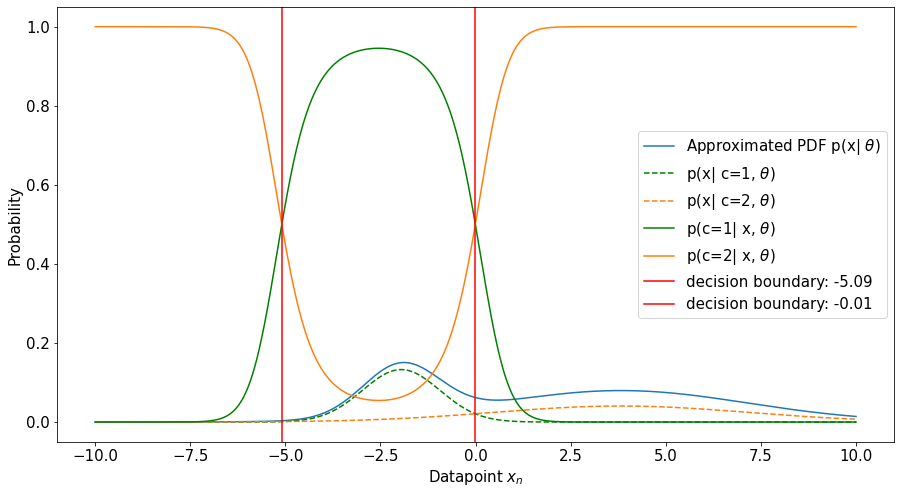

In [49]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(x, pdf_combined(x, **final_parameters_task_b), label=r"Approximated PDF p(x| $\theta$)")
ax.plot(x, p_1, linestyle="--", label=r"p(x| c=1, $\theta$)", color="green")
ax.plot(x, p_2, linestyle="--", label=r"p(x| c=2, $\theta$)", color="C1")
ax.plot(x, posterior_1, linestyle="-", label=r"p(c=1| x, $\theta$)", color="green")
ax.plot(x, posterior_2, linestyle="-", label=r"p(c=2| x, $\theta$)", color="C1")
ax.axvline(x[dec_bound[0]], color="red", label=f"decision boundary: {round(x[dec_bound[0]], 2)}")
ax.axvline(x[dec_bound[1]], color="red", label=f"decision boundary: {round(x[dec_bound[1]], 2)}")
ax.legend(fontsize=15)
ax.set_xlabel("Datapoint $x_n$", fontsize=15)
ax.set_ylabel("Probability", fontsize=15)

## Based on the lecture we know that the decision boundaries are equal to the intersection points of the posterior probabilities. (eq. 67)